# Import The Useable Libraries:

In [1]:
import numpy as np
import pandas as pd
import string
import random
from time import time
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad
from Crypto.Random import get_random_bytes
import base64
from Crypto.Util.Padding import unpad
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from decimal import Decimal, getcontext
import scienceplots

# **Define The Global Notebook Settings:** 

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 50)
pd.set_option("display.max_columns", 500)
plt.rcParams.update({'font.size': 14})
plt.style.use(['science', 'no-latex'])
plt.rcParams['font.family'] = 'Times New Roman'

# **Define The Global Variables:** 

In [3]:
def get_random_8chars(chars_length, n_sambles):
    random_chars = []
    for i in range(0, n_sambles, 1):
        letters = string.ascii_letters
        random_chars.append("".join(random.choice(letters)
                            for _ in range(chars_length)))
    return "".join(random_chars)

In [4]:
polynomials = [
    ([2, 2.5, 3], [2, -2, -3]),
    ([3, 3.5, 4, 4.5], [3, 3.7, -4, -4.5]),
    ([4, 4.5, 5, 5.5, 6], [4, 4.3, 5, -5.5, -6]),
    ([5, 5.5, 6, 6.5, 7, 7.5], [5, 5.3, 6, -6.5, -7, -7.5]),
    ([6, 6.5, 7, 7.5, 8, 8.5, 9], [6, 6.7, 7, 7.5, -8, -8.5, -9]),
]

In [5]:
Degrees = []
for poly in polynomials:
    Degrees.append(len(poly[0]) - 1)

In [6]:
block_size = 5

min_block = ' '*block_size
max_block = '~'*block_size

min_rep = int.from_bytes(
    min_block.encode('utf-8'), byteorder='big')
max_rep = int.from_bytes(
    max_block.encode('utf-8'), byteorder='big')

print(min_rep, max_rep)

137977929760 543288098430


In [7]:
text_samples = []
text_sizes = [5000, 7500, 10000, 12500, 15000,
              17500, 20000, 22500, 25000, 27500, 30000]
for size in text_sizes:
    text_samples.append(get_random_8chars(block_size, size))

In [8]:
bisection_different_deg_enc = []
bisection_different_deg_dec = []
bisection_different_deg_total = []

bisection_different_sizes_enc = []
bisection_different_sizes_dec = []
bisection_different_sizes_total = []

# ====================

fposition_different_deg_enc = []
fposition_different_deg_dec = []
fposition_different_deg_total = []

fposition_different_sizes_enc = []
fposition_different_sizes_dec = []
fposition_different_sizes_total = []

# ====================

secant_different_deg_enc = []
secant_different_deg_dec = []
secant_different_deg_total = []

secant_different_sizes_enc = []
secant_different_sizes_dec = []
secant_different_sizes_total = []

# ====================

hybridbf_different_deg_enc = []
hybridbf_different_deg_dec = []
hybridbf_different_deg_total = []

hybridbf_different_sizes_enc = []
hybridbf_different_sizes_dec = []
hybridbf_different_sizes_total = []

# ====================

hybridsf_different_deg_enc = []
hybridsf_different_deg_dec = []
hybridsf_different_deg_total = []

hybridsf_different_sizes_enc = []
hybridsf_different_sizes_dec = []
hybridsf_different_sizes_total = []

# **Define The Global Classes:** 

In [9]:
class ibga(object):
    def __init__(self, text, x, y):
        if type(text) != str or len(x) != len(y):
            raise ValueError("Invalid parameters passed")
        self.text = text
        self.len_text = len(text)
        self.x = [Decimal(i) for i in x]
        self.y = [Decimal(i) for i in y]
        self.coefs = None
        self.maximium_8utf_chars = Decimal(max_rep)
        self.minimum_8utf_chars = Decimal(min_rep)
        self.len_x = len(x)

    def set_text(self, text):
        if type(text) != str:
            raise ValueError("Invalid text type passed")
        self.text = text

    def set_x_y(self, x, y):
        if len(x) != len(y):
            raise ValueError("Invalid x, y points size passed")
        self.x = [Decimal(i) for i in x]
        self.y = [Decimal(i) for i in y]
        self.len_x = len(x)
        self.coefs = None

    def encode_and_get_int_values(self, chunk):
        byte_representation = chunk.encode('utf-8')
        integer_representation = int.from_bytes(
            byte_representation, byteorder='big')
        return integer_representation

    def get_normalized_value(self, integer_value):
        decimal_value = Decimal(integer_value)
        normalized_value = (decimal_value - self.minimum_8utf_chars) / \
            (self.maximium_8utf_chars - self.minimum_8utf_chars)
        return normalized_value

    def get_inverse_normalized_value(self, normalized_value):
        integer_value = (normalized_value *
                         (self.maximium_8utf_chars - self.minimum_8utf_chars)) + self.minimum_8utf_chars
        return integer_value

    def get_normalized_values(self):
        normalized_values = []
        chunks = self.len_text // block_size
        beg, end = 0, 0
        if chunks:
            end = block_size
            for i in range(0, chunks, 1):
                chunk = self.text[beg: end]
                normalized_values.append(
                    self.get_normalized_value(self.encode_and_get_int_values(chunk)))
                beg = end
                end = beg + block_size
        if (self.len_text / block_size) % 1 != 0:
            chunk = self.text[end:]
            normalized_values.append(
                self.get_normalized_value(self.encode_and_get_int_values(chunk)))
        return normalized_values

    def get_interger_values(self, normalized_values):
        interger_values = []
        for normalized_value in normalized_values:
            interger_values.append(
                self.get_inverse_normalized_value(normalized_value))
        return interger_values

    def decode_and_get_strings(self, int_values):
        strings = []
        for int_value in int_values:
            int_value = np.ceil(int_value)
            byte_representation = int_value.to_bytes(
                (int_value.bit_length() + 7) // 8, byteorder='big')
            text = byte_representation.decode('utf-8')
            strings.append(text)
        return "".join(strings)

    def decode_and_get_string(self, int_value):
        int_value = np.ceil(int_value)
        byte_representation = int_value.to_bytes(
            (int_value.bit_length() + 7) // 8, byteorder='big')
        return (byte_representation.decode('utf-8'))

    def newton_forward_coefficients(self):
        n = len(self.x)
        coefficients = np.zeros(n, dtype=Decimal)
        for i in range(n):
            coefficients[i] = Decimal(self.y[i])
        for j in range(1, n):
            for i in range(n - 1, j - 1, -1):
                coefficients[i] = (coefficients[i] - coefficients[i - 1]) / \
                    (self.x[i] - self.x[i - j])
        self.coefs = coefficients

    def evaluate_interpolated_value(self, target, normalized_value=Decimal(0)):
        n = self.len_x
        result = Decimal(self.coefs[-1])
        for i in range(n - 2, -1, -1):
            result = Decimal(result) * \
                (Decimal(target) - Decimal(self.x[i])) + Decimal(self.coefs[i])
        return result - normalized_value

    def evaluate_derivative(self, x, normalized_value):
        n = len(self.coefs) - 1
        result = Decimal(n) * (self.coefs[-1] - normalized_value)
        for i in range(n - 1, 0, -1):
            result = result * \
                (Decimal(x) - Decimal(self.x[i])) + Decimal(i) * self.coefs[i]
        return result

    def secant(self, x0, x1, normalized_value, tol=Decimal(10 ** -15)):
        x_prev = Decimal(x0)
        x_curr = Decimal(x1)

        while abs(x_curr - x_prev) > tol:
            fx_prev = self.evaluate_interpolated_value(
                x_prev, normalized_value)
            fx_curr = self.evaluate_interpolated_value(
                x_curr, normalized_value)

            if fx_curr - fx_prev == 0:
                raise ValueError(
                    "Secant method cannot converge. Division by zero.")

            x_next = x_curr - fx_curr * (x_curr - x_prev) / (fx_curr - fx_prev)
            x_prev, x_curr = x_curr, x_next

        return x_curr

    def bisection(self, a, b, normalized_value, tol=Decimal(10 ** -15)):
        if self.evaluate_interpolated_value(a, normalized_value) * self.evaluate_interpolated_value(b, normalized_value) > 0:
            raise ValueError(
                "The function values at the endpoints must have different signs.")

        while abs(b - a) > tol:
            midpoint = (a + b) / Decimal(2)
            if self.evaluate_interpolated_value(midpoint, normalized_value) == Decimal(0):
                return midpoint
            elif self.evaluate_interpolated_value(midpoint, normalized_value) * self.evaluate_interpolated_value(a, normalized_value) < 0:
                b = midpoint
            else:
                a = midpoint

        return midpoint

    def newton(self, initial_guess, normalized_value, tol=Decimal(10 ** -15), max_iter=70):
        x_guess = Decimal(initial_guess)
        for _ in range(max_iter):
            fx = self.evaluate_interpolated_value(x_guess, normalized_value)
            dfx = self.evaluate_derivative(x_guess, normalized_value)
            if dfx == Decimal(0):
                raise ValueError(
                    "Derivative is zero. Newton-Raphson method cannot converge.")
            x_guess -= fx / dfx
            if abs(fx) < tol:
                return x_guess
        return x_guess

    def false_position(self, a, b, normalized_value, tol=Decimal(10 ** -15)):
        if self.evaluate_interpolated_value(a, normalized_value) * self.evaluate_interpolated_value(b, normalized_value) > 0:
            raise ValueError(
                "The function values at the endpoints must have different signs.")

        while True:
            fa = self.evaluate_interpolated_value(a, normalized_value)
            fb = self.evaluate_interpolated_value(b, normalized_value)
            if fa == Decimal(0):
                return a
            if fb == Decimal(0):
                return b

            x_next = (a * fb - b * fa) / (fb - fa)
            fx_next = self.evaluate_interpolated_value(
                x_next, normalized_value)

            if abs(fx_next) < tol:
                return x_next

            if fx_next * fa < 0:
                b = x_next
            else:
                a = x_next

    def hybridBF(self, a, b, normalized_value, tol=Decimal(10 ** -15)):
        # Initialize the variables
        n = 0
        a1 = a
        a2 = a
        b1 = b
        b2 = b

        while True:
            # Increment the iteration counter
            n += 1

            # Evaluate the function at the endpoints
            fa = self.evaluate_interpolated_value(a, normalized_value)
            fb = self.evaluate_interpolated_value(b, normalized_value)

            # Compute the midpoint and the false position point
            xB = (a + b) / 2
            fxB = self.evaluate_interpolated_value(xB, normalized_value)

            xF = a - (fa * (b - a)) / (fb - fa)
            fxF = self.evaluate_interpolated_value(xF, normalized_value)

            # Choose the one with the smaller absolute value as the root approximation
            if abs(fxB) < abs(fxF):
                x = xB
                fx = fxB
            else:
                x = xF
                fx = fxF

            # Check if the absolute value of fx is less than or equal to the tolerance
            if abs(fx) <= tol:
                # Return the output
                return x

            # Update the interval by applying the bisection and false position methods
            if fa * fxB < 0:
                b1 = xB
            else:
                a1 = xB

            if fa * fxF < 0:
                b2 = xF
            else:
                a2 = xF

            # Set a to the maximum of a1 and a2 and b to the minimum of b1 and b2
            a = max(a1, a2)
            b = min(b1, b2)

    def hybridSF(self, a, b, normalized_value, tol=Decimal(10 ** -15)):
        n = 0

        while True:
            n += 1

            fa = self.evaluate_interpolated_value(a, normalized_value)
            fb = self.evaluate_interpolated_value(b, normalized_value)

            x_val = a - (fa * (b - a)) / (fb - fa)
            fx = self.evaluate_interpolated_value(x_val, normalized_value)

            if abs(fx) <= tol:
                return x_val

            aS = b
            bS = x_val

            faS = fb
            fbS = fx

            xS = bS - fbS * (bS - aS) / (fbS - faS)
            fxS = self.evaluate_interpolated_value(xS, normalized_value)

            if abs(fxS) < abs(fx) and a < xS < b:
                if fa * fxS < 0:
                    b = xS
                else:
                    a = xS
            else:
                if fa * fx < 0:
                    b = x_val
                else:
                    a = x_val

    def encryption(self, root_finding_algorithm='secant'):
        cipher_text = []
        self.newton_forward_coefficients()
        normalized_values = self.get_normalized_values()
        algorithms = {
            'bisection': self.bisection,
            'false_position': self.false_position,
            'secant': self.secant,
            'newton': self.newton,
            'hybridBF': self.hybridBF,
            'hybridSF': self.hybridSF
        }
        if root_finding_algorithm not in algorithms:
            raise ValueError(
                f"Invalid algorithm_name. Expected one of: {', '.join(algorithms.keys())}")

        selected_algorithm = algorithms[root_finding_algorithm]

        for normalized_value in normalized_values:
            cipher_text.append(selected_algorithm(
                self.x[0], self.x[-1], normalized_value))

        return cipher_text

    def decryption(self, cipher_text):
        text = []
        for root in cipher_text:
            norm = self.evaluate_interpolated_value(root)
            inverse = self.get_inverse_normalized_value(norm)
            text.append(self.decode_and_get_string(Decimal(round(inverse))))
        return "".join(text)

# Get The Encryption & Decrytion & Total Times For Bisection , Secant Hyprid With Differrent Polynomials Degree 2 : 6

> **Hint**: 
> 1)  According To The Useable Root Finding Algorithm Uncomment Its Callable Function Inside The Encryption Function. 
> 2) Root Finding Algorithms Analysis Woerking With Block Size 4bytes For (Bisection , False Position).

### Get Encryption , Decryption , Total Times When Using **Bisction**: 

In [10]:
poly = polynomials[3]
for text in text_samples:
    obj = ibga(text, poly[0], poly[1])
    ibga_en_beg = time()
    ciper_text = obj.encryption('bisection')
    ibga_en_end = time()
    en_time = ibga_en_end - ibga_en_beg
    bisection_different_sizes_enc.append(en_time)

    ibga_dec_beg = time()
    text_decryption = obj.decryption(ciper_text)
    ibga_dec_end = time()
    dec_time = ibga_dec_end - ibga_dec_beg
    bisection_different_sizes_dec.append(dec_time)

    bisection_different_sizes_total.append(en_time + dec_time)
    print(text_decryption == text)

print('='*10)

text = text_samples[4]
for poly in polynomials:
    obj = ibga(text, poly[0], poly[1])
    ibga_en_beg = time()
    ciper_text = obj.encryption('bisection')
    ibga_en_end = time()
    en_time = ibga_en_end - ibga_en_beg
    bisection_different_deg_enc.append(en_time)

    ibga_dec_beg = time()
    text_decryption = obj.decryption(ciper_text)
    ibga_dec_end = time()
    dec_time = ibga_dec_end - ibga_dec_beg
    bisection_different_deg_dec.append(dec_time)

    bisection_different_deg_total.append(en_time + dec_time)
    print(text_decryption == text)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


### **Get Encryption , Decryption , Total Times When Using False Position:** 

In [11]:
poly = polynomials[3]
for text in text_samples:
    obj = ibga(text, poly[0], poly[1])
    ibga_en_beg = time()
    ciper_text = obj.encryption('false_position')
    ibga_en_end = time()
    en_time = ibga_en_end - ibga_en_beg
    fposition_different_sizes_enc.append(en_time)

    ibga_dec_beg = time()
    text_decryption = obj.decryption(ciper_text)
    ibga_dec_end = time()
    dec_time = ibga_dec_end - ibga_dec_beg
    fposition_different_sizes_dec.append(dec_time)

    fposition_different_sizes_total.append(en_time + dec_time)
    print(text_decryption == text)

print('='*10)

text = text_samples[4]
for poly in polynomials:
    obj = ibga(text, poly[0], poly[1])
    ibga_en_beg = time()
    ciper_text = obj.encryption('false_position')
    ibga_en_end = time()
    en_time = ibga_en_end - ibga_en_beg
    fposition_different_deg_enc.append(en_time)

    ibga_dec_beg = time()
    text_decryption = obj.decryption(ciper_text)
    ibga_dec_end = time()
    dec_time = ibga_dec_end - ibga_dec_beg
    fposition_different_deg_dec.append(dec_time)

    fposition_different_deg_total.append(en_time + dec_time)
    print(text_decryption == text)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


### **Get Encryption , Decryption , Total Times When Using Secant:** 

In [12]:
poly = polynomials[3]
for text in text_samples:
    obj = ibga(text, poly[0], poly[1])
    ibga_en_beg = time()
    ciper_text = obj.encryption('secant')
    ibga_en_end = time()
    en_time = ibga_en_end - ibga_en_beg
    secant_different_sizes_enc.append(en_time)

    ibga_dec_beg = time()
    text_decryption = obj.decryption(ciper_text)
    ibga_dec_end = time()
    dec_time = ibga_dec_end - ibga_dec_beg
    secant_different_sizes_dec.append(dec_time)

    secant_different_sizes_total.append(en_time + dec_time)
    print(text_decryption == text)

print('='*10)

text = text_samples[4]
for poly in polynomials:
    obj = ibga(text, poly[0], poly[1])
    ibga_en_beg = time()
    ciper_text = obj.encryption('secant')
    ibga_en_end = time()
    en_time = ibga_en_end - ibga_en_beg
    secant_different_deg_enc.append(en_time)

    ibga_dec_beg = time()
    text_decryption = obj.decryption(ciper_text)
    ibga_dec_end = time()
    dec_time = ibga_dec_end - ibga_dec_beg
    secant_different_deg_dec.append(dec_time)

    secant_different_deg_total.append(en_time + dec_time)
    print(text_decryption == text)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


### **Get Encryption , Decryption , Total Times When Using HybridBF:** 

In [13]:
poly = polynomials[3]
for text in text_samples:
    obj = ibga(text, poly[0], poly[1])
    ibga_en_beg = time()
    ciper_text = obj.encryption('hybridBF')
    ibga_en_end = time()
    en_time = ibga_en_end - ibga_en_beg
    hybridbf_different_sizes_enc.append(en_time)

    ibga_dec_beg = time()
    text_decryption = obj.decryption(ciper_text)
    ibga_dec_end = time()
    dec_time = ibga_dec_end - ibga_dec_beg
    hybridbf_different_sizes_dec.append(dec_time)

    hybridbf_different_sizes_total.append(en_time + dec_time)
    print(text_decryption == text)

print('='*10)

text = text_samples[4]
for poly in polynomials:
    obj = ibga(text, poly[0], poly[1])
    ibga_en_beg = time()
    ciper_text = obj.encryption('hybridBF')
    ibga_en_end = time()
    en_time = ibga_en_end - ibga_en_beg
    hybridbf_different_deg_enc.append(en_time)

    ibga_dec_beg = time()
    text_decryption = obj.decryption(ciper_text)
    ibga_dec_end = time()
    dec_time = ibga_dec_end - ibga_dec_beg
    hybridbf_different_deg_dec.append(dec_time)

    hybridbf_different_deg_total.append(en_time + dec_time)
    print(text_decryption == text)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


### **Get Encryption , Decryption , Total Times When Using HybridSF:** 

In [14]:
poly = polynomials[3]
for text in text_samples:
    obj = ibga(text, poly[0], poly[1])
    ibga_en_beg = time()
    ciper_text = obj.encryption('hybridSF')
    ibga_en_end = time()
    en_time = ibga_en_end - ibga_en_beg
    hybridsf_different_sizes_enc.append(en_time)

    ibga_dec_beg = time()
    text_decryption = obj.decryption(ciper_text)
    ibga_dec_end = time()
    dec_time = ibga_dec_end - ibga_dec_beg
    hybridsf_different_sizes_dec.append(dec_time)

    hybridsf_different_sizes_total.append(en_time + dec_time)
    print(text_decryption == text)

print('='*10)

text = text_samples[4]
for poly in polynomials:
    obj = ibga(text, poly[0], poly[1])
    ibga_en_beg = time()
    ciper_text = obj.encryption('hybridSF')
    ibga_en_end = time()
    en_time = ibga_en_end - ibga_en_beg
    hybridsf_different_deg_enc.append(en_time)

    ibga_dec_beg = time()
    text_decryption = obj.decryption(ciper_text)
    ibga_dec_end = time()
    dec_time = ibga_dec_end - ibga_dec_beg
    hybridsf_different_deg_dec.append(dec_time)

    hybridsf_different_deg_total.append(en_time + dec_time)
    print(text_decryption == text)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


---

In [15]:
# Polynomial Deg & Text Array Size
print(polynomials)
polynomials_degrees = []
for poly in polynomials:
    polynomials_degrees.append(len(poly[0]) - 1)

print(polynomials_degrees)
print(text_sizes)

[([2, 2.5, 3], [2, -2, -3]), ([3, 3.5, 4, 4.5], [3, 3.7, -4, -4.5]), ([4, 4.5, 5, 5.5, 6], [4, 4.3, 5, -5.5, -6]), ([5, 5.5, 6, 6.5, 7, 7.5], [5, 5.3, 6, -6.5, -7, -7.5]), ([6, 6.5, 7, 7.5, 8, 8.5, 9], [6, 6.7, 7, 7.5, -8, -8.5, -9])]
[2, 3, 4, 5, 6]
[5000, 7500, 10000, 12500, 15000, 17500, 20000, 22500, 25000, 27500, 30000]


In [16]:
# Time Results
print(bisection_different_deg_enc)
print(bisection_different_deg_dec)
print(bisection_different_deg_total)

print(bisection_different_sizes_enc)
print(bisection_different_sizes_dec)
print(bisection_different_sizes_total)

print(fposition_different_deg_enc)
print(fposition_different_deg_dec)
print(fposition_different_deg_total)

print(fposition_different_sizes_enc)
print(fposition_different_sizes_dec)
print(fposition_different_sizes_total)

print(secant_different_deg_enc)
print(secant_different_deg_dec)
print(secant_different_deg_total)

print(secant_different_sizes_enc)
print(secant_different_sizes_dec)
print(secant_different_sizes_total)

[12.012930631637573, 16.5152747631073, 20.66884207725525, 24.70430302619934, 28.4143328666687]
[0.29465341567993164, 0.3273890018463135, 0.35323166847229004, 0.38535618782043457, 0.3714730739593506]
[12.307584047317505, 16.842663764953613, 21.02207374572754, 25.089659214019775, 28.78580594062805]
[12.107164859771729, 13.07826566696167, 16.924850463867188, 20.842782974243164, 25.760764837265015, 28.969894409179688, 34.9391188621521, 39.71575331687927, 41.66539669036865, 46.27203297615051, 49.364399433135986]
[0.13112235069274902, 0.17570900917053223, 0.2890892028808594, 0.34060120582580566, 0.42707324028015137, 0.4565849304199219, 0.5321483612060547, 0.5336709022521973, 0.63358473777771, 0.6783392429351807, 0.720710039138794]
[12.238287210464478, 13.253974676132202, 17.213939666748047, 21.18338418006897, 26.187838077545166, 29.42647933959961, 35.471267223358154, 40.24942421913147, 42.29898142814636, 46.95037221908569, 50.08510947227478]
[3.988847255706787, 3.210820436477661, 5.643304824

## Plotting Results:

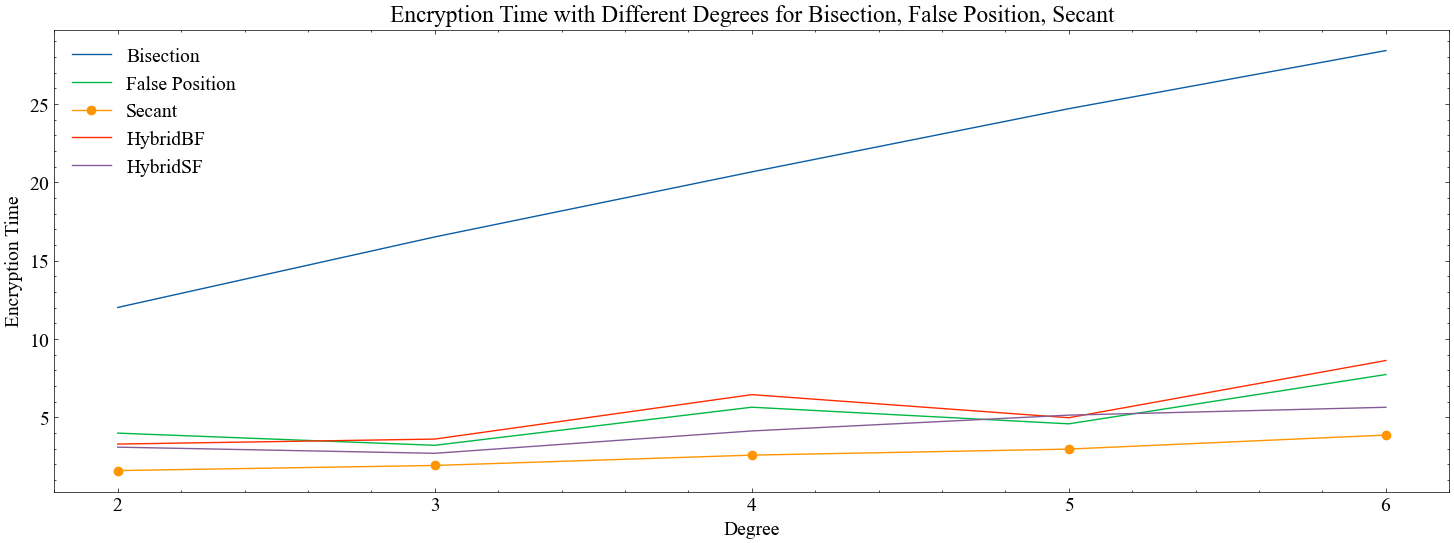

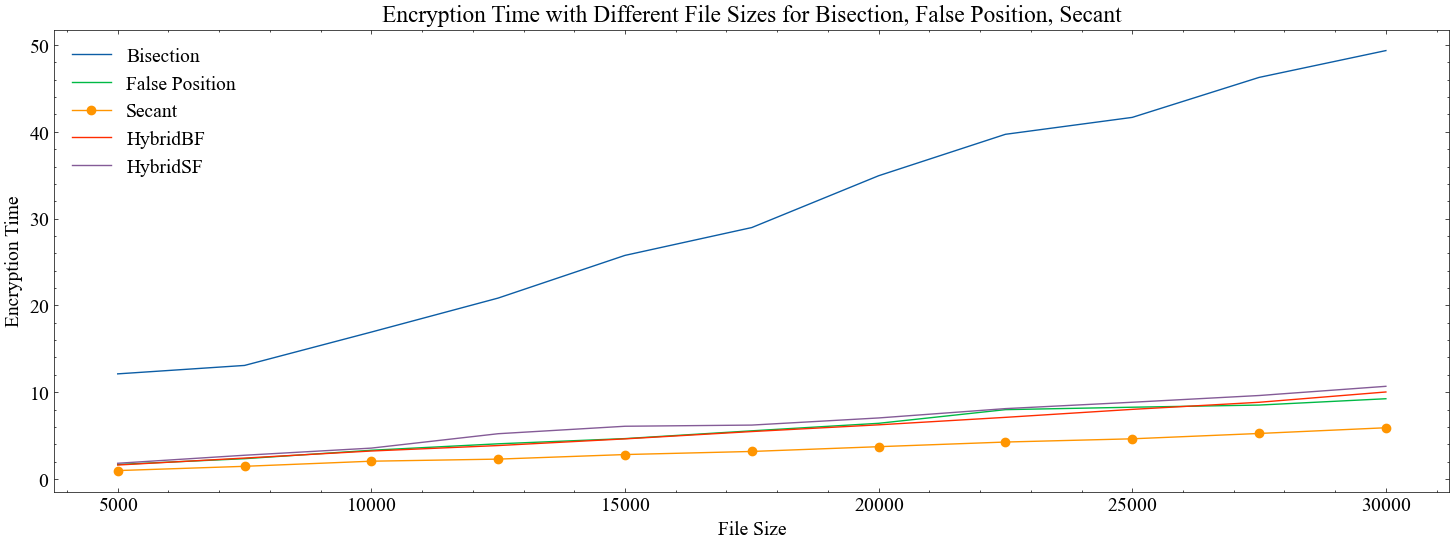

In [17]:
plt.figure(figsize=(18, 6))
plt.plot(polynomials_degrees,
         bisection_different_deg_enc, label='Bisection')
plt.plot(polynomials_degrees,
         fposition_different_deg_enc, label='False Position')
plt.plot(polynomials_degrees, secant_different_deg_enc,
         '-o', label='Secant')
plt.plot(polynomials_degrees,
         hybridbf_different_deg_enc, label='HybridBF')
plt.plot(polynomials_degrees,
         hybridsf_different_deg_enc, label='HybridSF')

plt.xlabel('Degree')
plt.ylabel('Encryption Time')
plt.title(
    'Encryption Time with Different Degrees for Bisection, False Position, Secant')

# Set xticks to only integer degrees
plt.xticks(np.arange(min(polynomials_degrees),
           max(polynomials_degrees)+1, 1.0))

plt.legend()
plt.savefig(r"./different_deg_enc_time.svg", format="svg")
plt.show()


# Encryption Time with Different File Sizes
plt.figure(figsize=(18, 6))
plt.plot(text_sizes, bisection_different_sizes_enc, label='Bisection')
plt.plot(text_sizes, fposition_different_sizes_enc,
         label='False Position')
plt.plot(text_sizes, secant_different_sizes_enc, '-o', label='Secant')
plt.plot(text_sizes, hybridbf_different_sizes_enc, label='HybridBF')
plt.plot(text_sizes, hybridsf_different_sizes_enc, label='HybridSF')

plt.xlabel('File Size')
plt.ylabel('Encryption Time')
plt.title(
    'Encryption Time with Different File Sizes for Bisection, False Position, Secant')
plt.legend()
plt.savefig(r"./different_sizes_enc_time.svg", format="svg")
plt.show()

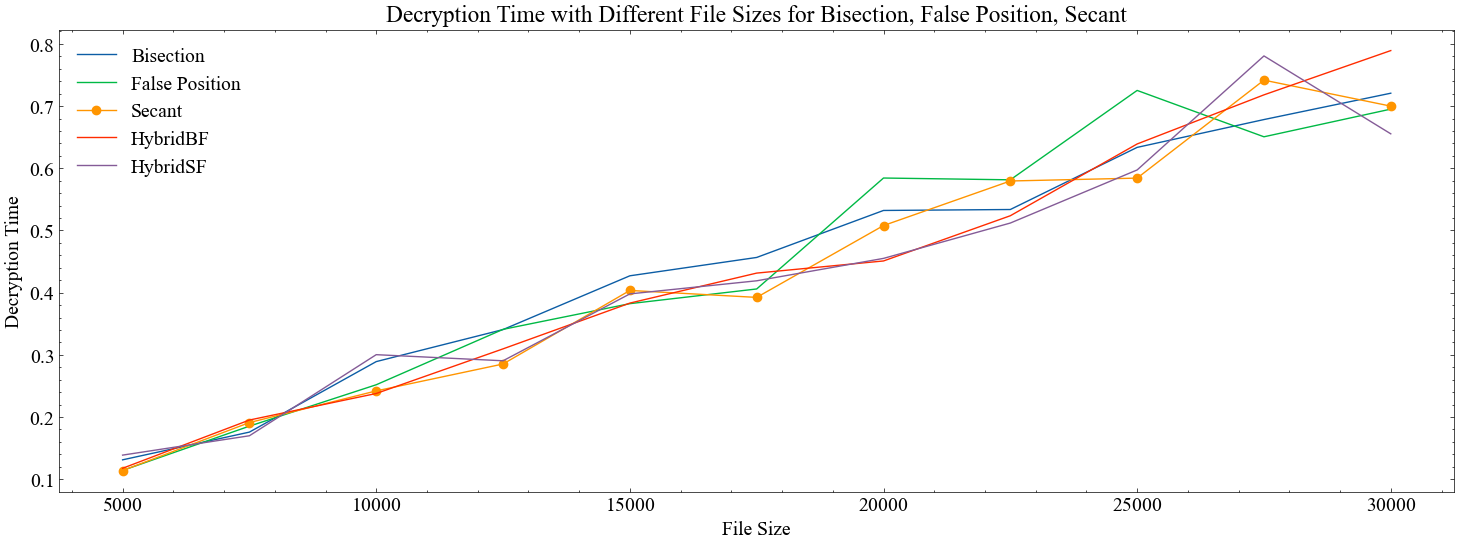

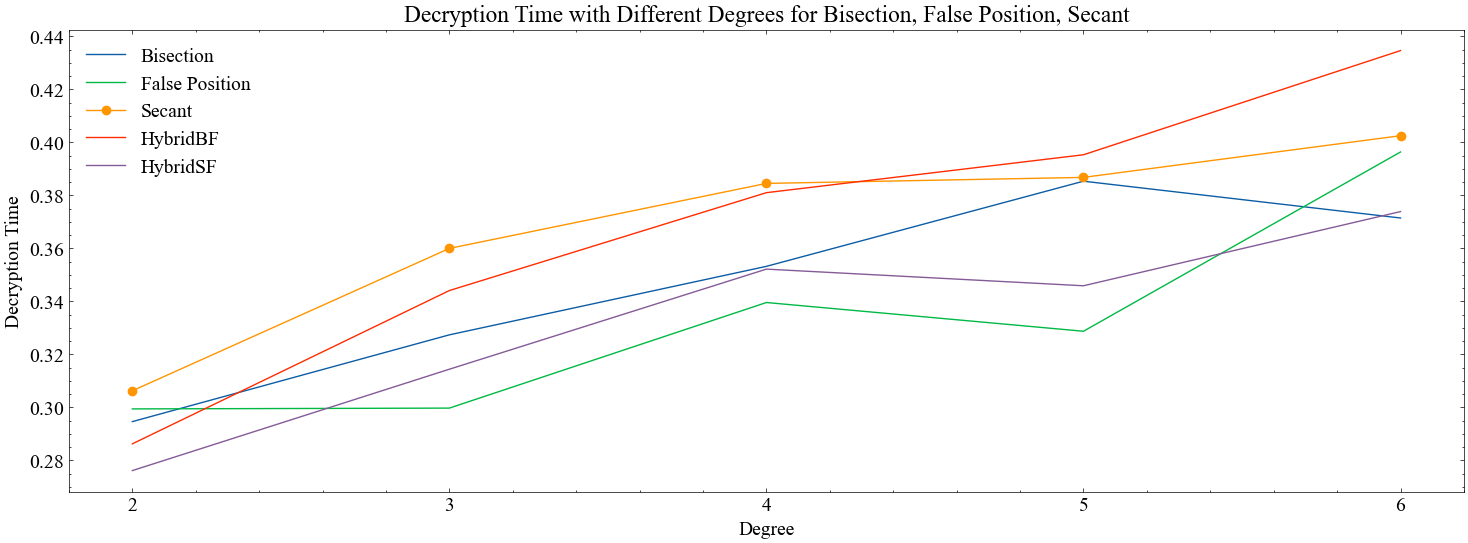

In [18]:
# Decryption Time with Different File Sizes
plt.figure(figsize=(18, 6))
plt.plot(text_sizes, bisection_different_sizes_dec, label='Bisection')
plt.plot(text_sizes, fposition_different_sizes_dec,
         label='False Position')
plt.plot(text_sizes, secant_different_sizes_dec, '-o', label='Secant')
plt.plot(text_sizes, hybridbf_different_sizes_dec, label='HybridBF')
plt.plot(text_sizes, hybridsf_different_sizes_dec, label='HybridSF')

plt.xlabel('File Size')
plt.ylabel('Decryption Time')
plt.title(
    'Decryption Time with Different File Sizes for Bisection, False Position, Secant')
plt.legend()
plt.savefig(r"./different_sizes_dec_time.svg", format="svg")
plt.show()


# Decryption Time with Different Degrees
plt.figure(figsize=(18, 6))
plt.plot(polynomials_degrees,
         bisection_different_deg_dec, label='Bisection')
plt.plot(polynomials_degrees,
         fposition_different_deg_dec, label='False Position')
plt.plot(polynomials_degrees, secant_different_deg_dec,
         '-o', label='Secant')
plt.plot(polynomials_degrees,
         hybridbf_different_deg_dec, label='HybridBF')
plt.plot(polynomials_degrees,
         hybridsf_different_deg_dec, label='HybridSF')

plt.xlabel('Degree')
plt.ylabel('Decryption Time')
plt.title(
    'Decryption Time with Different Degrees for Bisection, False Position, Secant')
plt.legend()
# Set xticks to only integer degrees
plt.xticks(np.arange(min(polynomials_degrees),
           max(polynomials_degrees)+1, 1.0))

plt.savefig(r"./different_deg_dec_time.svg", format="svg")
plt.show()

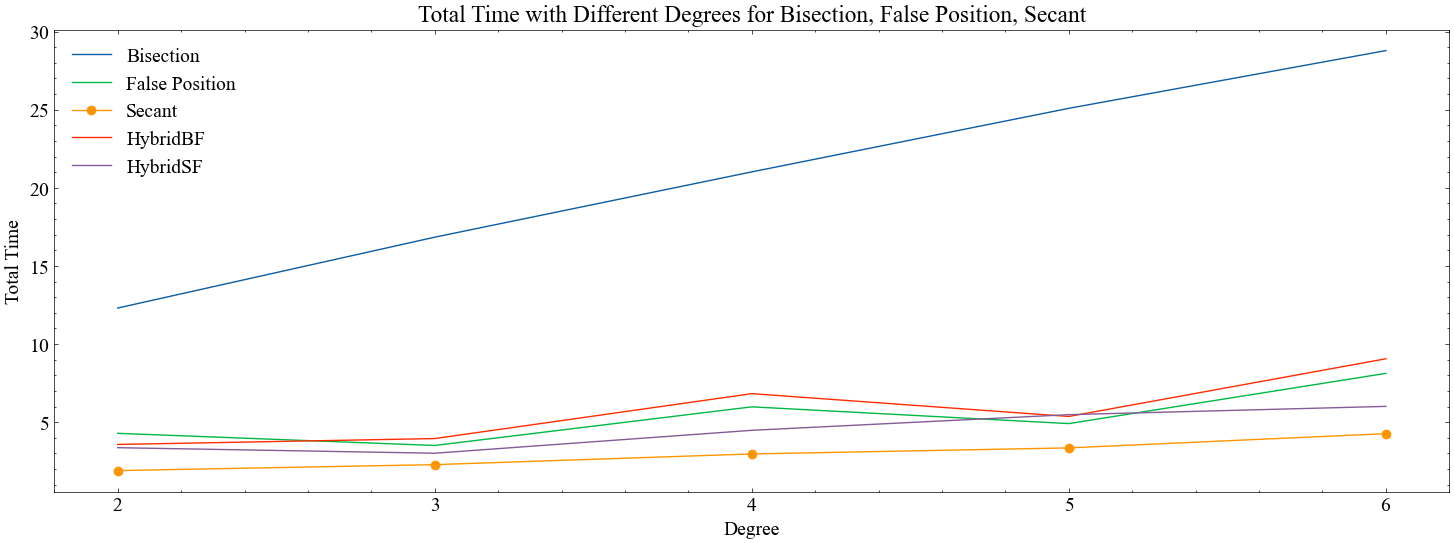

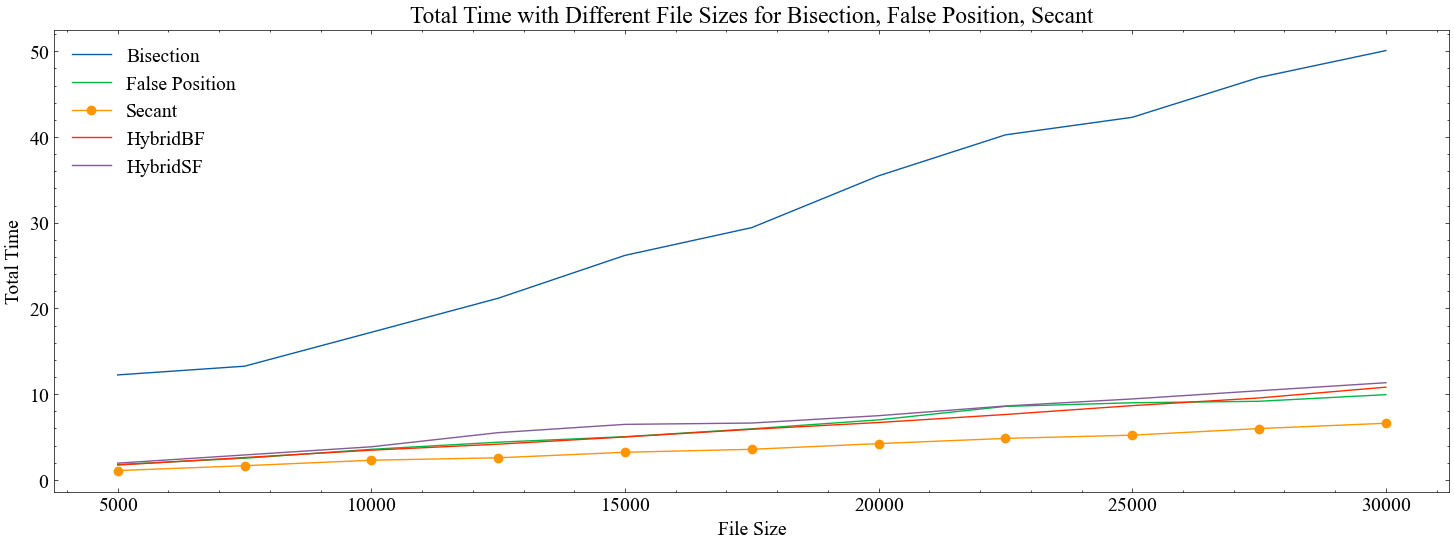

In [19]:
# Total Time with Different Degrees
plt.figure(figsize=(18, 6))
plt.plot(polynomials_degrees, bisection_different_deg_total, label='Bisection')
plt.plot(polynomials_degrees,
         fposition_different_deg_total, label='False Position')
plt.plot(polynomials_degrees, secant_different_deg_total,
         '-o', label='Secant')
plt.plot(polynomials_degrees, hybridbf_different_deg_total, label='HybridBF')
plt.plot(polynomials_degrees, hybridsf_different_deg_total, label='HybridSF')

plt.xlabel('Degree')
plt.ylabel('Total Time')
plt.title('Total Time with Different Degrees for Bisection, False Position, Secant')
plt.legend()
# Set xticks to only integer degrees
plt.xticks(np.arange(min(polynomials_degrees),
           max(polynomials_degrees)+1, 1.0))

plt.savefig(r"./different_deg_total_time.svg", format="svg")
plt.show()


# Total Time with Different File Sizes
plt.figure(figsize=(18, 6))
plt.plot(text_sizes, bisection_different_sizes_total, label='Bisection')
plt.plot(text_sizes, fposition_different_sizes_total, label='False Position')
plt.plot(text_sizes, secant_different_sizes_total, '-o', label='Secant')
plt.plot(text_sizes, hybridbf_different_sizes_total, label='HybridBF')
plt.plot(text_sizes, hybridsf_different_sizes_total, label='HybridSF')

plt.xlabel('File Size')
plt.ylabel('Total Time')
plt.title(
    'Total Time with Different File Sizes for Bisection, False Position, Secant')
plt.legend()
plt.savefig(r"./different_sizes_total_time.svg", format="svg")
plt.show()